In [4]:
!pip install streamlit
import streamlit as st
import random
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [5]:
# ---------------------------
# Funções do Algoritmo Genético
# ---------------------------

def criar_cromossomo(tempo_total, disciplinas, atividades_fisicas):
    cromossomo = []
    tempo_restante = tempo_total
    while tempo_restante > 0:
        tipo = random.choice(["estudo", "atividade_fisica", "descanso"])
        if tipo == "estudo":
            disciplina = random.choice(disciplinas)
            duracao = random.randint(30, 60)
            cromossomo.append({"tipo": "estudo", "disciplina": disciplina, "duracao": duracao})
        elif tipo == "atividade_fisica":
            atividade = random.choice(atividades_fisicas)
            duracao = random.randint(30, 45)
            cromossomo.append({"tipo": "atividade_fisica", "atividade": atividade, "duracao": duracao})
        else:
            duracao = random.randint(10, 15)
            cromossomo.append({"tipo": "descanso", "duracao": duracao})

        tempo_restante -= duracao
        if tempo_restante < 0:
            cromossomo[-1]["duracao"] += tempo_restante  # ajusta a duração do último bloco
    return cromossomo

def calcular_fitness(cromossomo, disciplinas_prioritarias):
    fitness = 1.0
    tempo_estudo = {}
    tempo_atividade_fisica = 0
    ultimo_foi_descanso = False
    tempo_desde_ultimo_descanso = 0

    for bloco in cromossomo:
        if bloco["tipo"] == "estudo":
            disciplina = bloco["disciplina"]
            duracao = bloco["duracao"]
            tempo_estudo[disciplina] = tempo_estudo.get(disciplina, 0) + duracao
            tempo_desde_ultimo_descanso += duracao
            ultimo_foi_descanso = False
        elif bloco["tipo"] == "atividade_fisica":
            duracao = bloco["duracao"]
            tempo_atividade_fisica += duracao
            tempo_desde_ultimo_descanso += duracao
            ultimo_foi_descanso = False
        else:
            tempo_desde_ultimo_descanso = 0
            ultimo_foi_descanso = True

        if tempo_desde_ultimo_descanso > 90 and not ultimo_foi_descanso:
            fitness *= 0.9  # Penaliza a falta de descanso a cada 90 minutos

    for disciplina in disciplinas_prioritarias:
        if tempo_estudo.get(disciplina, 0) < 60:
            fitness *= 0.8  # Penaliza estudo insuficiente
    if tempo_atividade_fisica < 30:
        fitness *= 0.85  # Penaliza atividade física insuficiente

    return fitness

def crossover(pai1, pai2):
    ponto_corte = random.randint(1, min(len(pai1), len(pai2)) - 1)
    filho1 = pai1[:ponto_corte] + pai2[ponto_corte:]
    filho2 = pai2[:ponto_corte] + pai1[ponto_corte:]
    return filho1, filho2

def mutacao(cromossomo, disciplinas, atividades_fisicas):
    indice_bloco = random.randint(0, len(cromossomo) - 1)
    bloco = cromossomo[indice_bloco]
    tipo = bloco["tipo"]
    if tipo == "estudo":
        bloco["disciplina"] = random.choice(disciplinas)
        bloco["duracao"] = random.randint(30, 60)
    elif tipo == "atividade_fisica":
        bloco["atividade"] = random.choice(atividades_fisicas)
        bloco["duracao"] = random.randint(30, 45)
    else:
        bloco["duracao"] = random.randint(10, 15)
    return cromossomo

def algoritmo_genetico(
    tempo_total,
    disciplinas,
    atividades_fisicas,
    disciplinas_prioritarias,
    tamanho_populacao,
    num_geracoes,
    taxa_crossover,
    taxa_mutacao
):
    populacao = [criar_cromossomo(tempo_total, disciplinas, atividades_fisicas)
                 for _ in range(tamanho_populacao)]

    fitness_history = []  # Para armazenar a melhor fitness de cada geração

    for geracao in range(num_geracoes):
        fitness_scores = [calcular_fitness(cromossomo, disciplinas_prioritarias)
                          for cromossomo in populacao]
        fitness_normalizado = [f / sum(fitness_scores) for f in fitness_scores]
        indices_selecionados = random.choices(range(tamanho_populacao), weights=fitness_normalizado, k=tamanho_populacao)
        nova_populacao = []

        for i in range(0, tamanho_populacao, 2):
            pai1 = populacao[indices_selecionados[i]]
            pai2 = populacao[indices_selecionados[i + 1]]
            if random.random() < taxa_crossover:
                filho1, filho2 = crossover(pai1, pai2)
            else:
                filho1, filho2 = pai1.copy(), pai2.copy()
            if random.random() < taxa_mutacao:
                filho1 = mutacao(filho1, disciplinas, atividades_fisicas)
            if random.random() < taxa_mutacao:
                filho2 = mutacao(filho2, disciplinas, atividades_fisicas)
            nova_populacao.extend([filho1, filho2])

        populacao = nova_populacao[:tamanho_populacao]
        melhor_fitness = max(fitness_scores)
        fitness_history.append(melhor_fitness)
        st.write(f"Geração {geracao + 1}: Melhor fitness = {melhor_fitness:.4f}")

    melhor_cromossomo = populacao[np.argmax(fitness_scores)]
    return melhor_cromossomo, fitness_history




In [12]:
# ---------------------------
# Interface com Streamlit
# ---------------------------

st.title("Otimização de Rotina de Estudos com Atividades Físicas")

st.markdown("Insira as informações abaixo para gerar a sua rotina otimizada:")

# Entrada: disciplinas (como lista separada por vírgulas)
disciplinas_input = st.text_input("Disciplinas que você precisa estudar (separadas por vírgula)", "Matemática, História, Física, Química")
disciplinas = [d.strip() for d in disciplinas_input.split(",") if d.strip()]

# Entrada: disciplinas prioritárias (opcional - pode ser selecionadas entre as disciplinas)
disciplinas_prioritarias = st.multiselect("Disciplinas prioritárias", disciplinas, default=["Matemática", "Física"])

# Entrada: atividades físicas (como lista separadas por vírgulas)
atividades_input = st.text_input("Atividades físicas que você pratica (separadas por vírgula)", "Caminhada, Yoga, Corrida, Musculação")
atividades_fisicas = [a.strip() for a in atividades_input.split(",") if a.strip()]

# Entrada: tempo total disponível (em minutos)
tempo_total = st.number_input("Tempo total disponível (em minutos)", min_value=60, max_value=600, value=240)

# Parâmetros do algoritmo genético (opcionais)
tamanho_populacao = st.number_input("Tamanho da população", min_value=10, max_value=100, value=50)
num_geracoes = st.number_input("Número de gerações", min_value=10, max_value=200, value=100)
taxa_crossover = st.slider("Taxa de Crossover", 0.0, 1.0, 0.8)
taxa_mutacao = st.slider("Taxa de Mutação", 0.0, 1.0, 0.1)

if st.button("Gerar Rotina"):
    st.write("Executando o algoritmo...")
    melhor_rotina, fitness_history = algoritmo_genetico(
        tempo_total,
        disciplinas,
        atividades_fisicas,
        disciplinas_prioritarias,
        tamanho_populacao,
        num_geracoes,
        taxa_crossover,
        taxa_mutacao
    )

    st.subheader("Melhor rotina encontrada:")
    for idx, bloco in enumerate(melhor_rotina):
        if bloco["tipo"] == "estudo":
            st.write(f"{idx + 1}. Estudo de **{bloco['disciplina']}** - {bloco['duracao']} minutos")
        elif bloco["tipo"] == "atividade_fisica":
            st.write(f"{idx + 1}. Atividade Física - **{bloco['atividade']}** - {bloco['duracao']} minutos")
        else:
            st.write(f"{idx + 1}. Descanso - {bloco['duracao']} minutos")



2025-05-20 00:50:00.269 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.270 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.273 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.275 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:50:00.276 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

2025-05-20 00:49:40.333 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-20 00:49:40.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


NameError: name 'fitness_history' is not defined

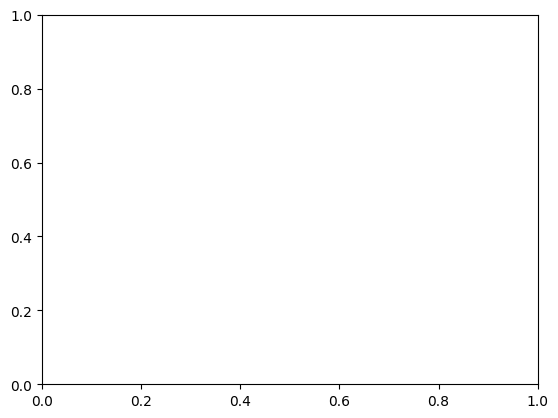

In [11]:
  # ---------------------------
    # Gráficos
    # ---------------------------

    # 1. Evolução da Fitness
st.subheader("Evolução da Fitness ao Longo das Gerações")
fig_fitness, ax_fitness = plt.subplots()
ax_fitness.plot(range(1, len(fitness_history) + 1), fitness_history)
ax_fitness.set_xlabel("Geração")
ax_fitness.set_ylabel("Melhor Fitness")
st.pyplot(fig_fitness)

    # 2. Distribuição do Tempo por Atividade
st.subheader("Distribuição do Tempo por Atividade")
tempo_por_atividade = {
  "Estudo": sum(bloco["duracao"] for bloco in melhor_rotina if bloco["tipo"] == "estudo"),
  "Atividade Física": sum(bloco["duracao"] for bloco in melhor_rotina if bloco["tipo"] == "atividade_fisica"),
  "Descanso": sum(bloco["duracao"] for bloco in melhor_rotina if bloco["tipo"] == "descanso")
    }
fig_atividades, ax_atividades = plt.subplots()
ax_atividades.pie(tempo_por_atividade.values(), labels=tempo_por_atividade.keys(), autopct="%1.1f%%", startangle=90)
st.pyplot(fig_atividades)

    # 3. Distribuição do Tempo por Disciplina
st.subheader("Distribuição do Tempo por Disciplina")
tempo_por_disciplina = {}
for bloco in melhor_rotina:
   if bloco["tipo"] == "estudo":
     disciplina = bloco["disciplina"]
     tempo_por_disciplina[disciplina] = tempo_por_disciplina.get(disciplina, 0) + bloco["duracao"]
fig_disciplinas, ax_disciplinas = plt.subplots()
ax_disciplinas.bar(tempo_por_disciplina.keys(), tempo_por_disciplina.values())
ax_disciplinas.set_xlabel("Disciplina")
ax_disciplinas.set_ylabel("Tempo (minutos)")
st.pyplot(fig_disciplinas)